In [1]:
import json
import pandas as pd
import re
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [2]:
with open('../notebooks/v1.0-simplified_nq-dev-all.jsonl', 'r') as json_file:
    json_list = list(json_file)

data = []
for json_str in json_list:
    data.append(json.loads(json_str))

In [25]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
def get_nq_tokens(simplified_nq_example):

    if "document_text" not in simplified_nq_example:
        raise ValueError("`get_nq_tokens` should be called on a simplified NQ"
                         "example that contains the `document_text` field.")

    return simplified_nq_example["document_text"].split(" ")


# this func is taken from official NaturalQuestions repo too
def simplify_nq_example(nq_example):

    def _clean_token(token):
        return re.sub(u" ", "_", token["token"])

    text = " ".join([_clean_token(t) for t in nq_example["document_tokens"]])

    def _remove_html_byte_offsets(span):
        if "start_byte" in span:
            del span["start_byte"]

        if "end_byte" in span:
            del span["end_byte"]

        return span

    def _clean_annotation(annotation):
        annotation["long_answer"] = _remove_html_byte_offsets(
            annotation["long_answer"])
        annotation["short_answers"] = [
            _remove_html_byte_offsets(sa) for sa in annotation["short_answers"]
        ]
        return annotation

    simplified_nq_example = {
      "question_text": nq_example["question_text"],
      "example_id": nq_example["example_id"],
      "document_url": nq_example["document_url"],
      "document_text": text,
      "long_answer_candidates": [
          _remove_html_byte_offsets(c)
          for c in nq_example["long_answer_candidates"]
      ],
      "annotations": [_clean_annotation(a) for a in nq_example["annotations"]]
    }

    if len(get_nq_tokens(simplified_nq_example)) != len(
      nq_example["document_tokens"]):
        raise ValueError("Incorrect number of tokens.")

    return simplified_nq_example

In [5]:
import re

import pandas as pd
from nltk.corpus import stopwords
from torch.utils.data import Dataset

In [6]:
class LongAnswerDatasetBase(Dataset):
    SAMPLE_RATE = 15
    
    def _get_nq_tokens(self, simplified_nq_example):
        if "document_text" not in simplified_nq_example:
            raise ValueError("`get_nq_tokens` should be called on a simplified NQ"
                         "example that contains the `document_text` field.")

        return simplified_nq_example["document_text"].split(" ")
    
    def _clean_token(self, token):
        return re.sub(u" ", "_", token["token"])

    def _remove_html_byte_offsets(self, span):
        if "start_byte" in span:
            del span["start_byte"]

        if "end_byte" in span:
            del span["end_byte"]

        return span

    def _clean_annotation(self, annotation):
        annotation["long_answer"] = self._remove_html_byte_offsets(
            annotation["long_answer"])
        annotation["short_answers"] = [
            self._remove_html_byte_offsets(sa) for sa in annotation["short_answers"]
        ]
        return annotation
    
    def _simplify_nq_example(self, nq_example):
        text = " ".join([self._clean_token(t) for t in nq_example["document_tokens"]])

        simplified_nq_example = {
          "question_text": nq_example["question_text"],
          "example_id": nq_example["example_id"],
          "document_url": nq_example["document_url"],
          "document_text": text,
          "long_answer_candidates": [
              self._remove_html_byte_offsets(c)
              for c in nq_example["long_answer_candidates"]
          ],
          "annotations": [self._clean_annotation(a) for a in nq_example["annotations"]]
        }

        if len(self._get_nq_tokens(simplified_nq_example)) != len(
          nq_example["document_tokens"]):
            raise ValueError("Incorrect number of tokens.")

        return simplified_nq_example
    
    def _get_question_and_document(self, line):
        question = line['question_text']
        text = line['document_text'].split(' ')
        annotations = line['annotations'][0]

        return question, text, annotations


    def _get_long_candidate(self, i, annotations, candidate):
        if i == annotations['long_answer']['candidate_index']:
            label = 1
        else:
            label = 0

        # get place where long answer starts and ends in the document text
        long_start = candidate['start_token']
        long_end = candidate['end_token']

        return label, long_start, long_end
    
    def _preprocess_data(self, data):
        rows = []

        for line in data:
            if not self._kaggle_format:
                line = self._simplify_nq_example(line)
            question, text, annotations = self._get_question_and_document(line)
            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = self._get_long_candidate(i, annotations, candidate)

                if label == True or (i % self.SAMPLE_RATE == 0):
                    rows.append(
                        self._form_data_row(question, label, text, long_start, long_end)
                    )

        return pd.DataFrame(rows)
    
    def _remove_stopwords(self, sentence):
        words = sentence.split()
        words = [word for word in words if word not in stopwords.words('english')]

        return ' '.join(words)

    def _remove_html(self, sentence):
        html = re.compile(r'<.*?>')
        return html.sub(r'', sentence)

    def _clean_df_by_column(self, df, column):
        df[column] = df[column].apply(lambda x : self._remove_stopwords(x))
        df[column] = df[column].apply(lambda x : self._remove_html(x))
        return df

    def _clean_df(self, df):
        df = self._clean_df_by_column(df, 'long_answer')
        df = self._clean_df_by_column(df, 'question')
        return df
    
    def __getitem__(self, idx):
        raise NotImplementedError('method __getitem__ is not implemented')
    
    def __len__(self):
        raise NotImplementedError('method __len__ is not implemented')

In [114]:
from sklearn.utils import resample, shuffle

In [118]:
class TrainLongAnswerDataset(LongAnswerDatasetBase):
    def __init__(self, data, tokenizer, max_len=150, kaggle_format=True, balance=True):
        self._tokenizer = tokenizer
        self._max_len = max_len
        self._kaggle_format = kaggle_format
        
        data = self._preprocess_data(data)
        data = self._clean_df(data)
        if balance:
            data = self._balance_data(data)
        self._questions = data.question.values
        self._long_answers = data.long_answer.values
        self._targets = data.is_long_answer.values
        
    
    def _balance_data(self, data):
        data_unbalanced_majority = data[data.is_long_answer == 0]
        data_unbalanced_minority = data[data.is_long_answer == 1]
        majority_size = data_unbalanced_majority.shape[0]
        data_balanced_minority = resample(data_unbalanced_minority, 
                                          replace=True,
                                          n_samples=majority_size)
        data_balanced = pd.concat([data_unbalanced_majority, data_balanced_minority])
        return shuffle(data_balanced).reset_index(drop=True)
        

    def _form_data_row(self, question, label, text, long_start, long_end):
        row = {
            'question': question,
            'long_answer': ' '.join(text[long_start:long_end]),
            'is_long_answer': label,
        }

        return row
    
    def __getitem__(self, idx):
        input_tokens = self._questions[idx].split()
        input_tokens.append(' ' + self._tokenizer.sep_token + ' ')
        long_answer_tokens = self._long_answers[idx].split()
        input_tokens.extend(long_answer_tokens)
        encoding = self._tokenizer(input_tokens,
                          is_split_into_words=True,
                          return_offsets_mapping=False,
                          return_token_type_ids=False,
                          padding='max_length',
                          truncation=True,
                          max_length=self._max_len,
                          return_tensors='pt')
        return encoding, self._targets[idx]

    def __len__(self):
        return self._targets.shape[0]

In [119]:
class TestLongAnswerDataset(LongAnswerDatasetBase):
    def __init__(self, data, tokenizer, max_len=150, kaggle_format=True):
        self._tokenizer = tokenizer
        self._max_len = max_len
        self._kaggle_format = kaggle_format
        
        data = self._preprocess_data(data)
        data = self._clean_df(data)
        self._data = {index: question_df for index, (question, question_df) in enumerate(data.groupby('question'))}

    def _form_data_row(self, question, label, text, long_start, long_end):
        row = {
            'question': question,
            'long_answer': ' '.join(text[long_start:long_end]),
            'is_long_answer': label,
            'long_start': long_start,
            'long_end': long_end
        }

        return row

    def __getitem__(self, idx):
        labels, texts, indices = [], [], []
        current_data = self._data[idx]
        for i in range(current_data.shape[0]):
            question = current_data.question.iloc[i]
            answer = current_data.long_answer.iloc[i]
            start = current_data.long_start.iloc[i]
            end = current_data.long_end.iloc[i]
            
            texts.append(question + self._tokenizer.sep_token + answer)
            labels.append(current_data.is_long_answer.iloc[i])
            indices.append(f"{start}:{end}")
            
        encoding = self._tokenizer(texts,
                                   return_offsets_mapping=False,
                                   return_token_type_ids=False,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=self._max_len,
                                   return_tensors='pt')
        return encoding, labels, indices
   
    def __len__(self):
        return len(self._data)

In [9]:
from torch.nn import DataParallel

In [76]:
class LongAnswerModel():
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
#         self.model.to(device)
        
        # PARALLEL
        self.model = DataParallel(self.model).to(device)
        
    def __call__(self, input_ids, attn_mask):
        
        self.model.eval()
        
        with torch.no_grad():
            
            input_ids = input_ids.to(self.device)
            output = self.model(input_ids=input_ids, attention_mask=attn_mask)
            logits = output['logits']
            active_logits = logits.view(-1, model.num_labels)
            flattened_pred = torch.argmax(active_logits, axis=1)
            if 1 in flattened_pred:
                ind = torch.argmax(active_logits[:, 1]).item()
                prediction = torch.zeros_like(flattened_pred)
                prediction[ind] = 1
                return prediction
        return flattened_pred
        
        
    def plot_log(self, train_losses, val_losses, val_fscores):
        clear_output()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 3))
        fig.suptitle('Training Log', fontsize=8)
        ax1.plot(train_losses)
        ax1.set_title('Train Loss', fontsize=8)
        ax1.tick_params(labelsize=6)
        ax2.plot(val_losses)
        ax2.set_title('Val Loss', fontsize=8)
        ax2.tick_params(labelsize=6)
        ax3.plot(val_fscores)
        ax3.set_title("Val F1", fontsize=8)
        ax3.tick_params(labelsize=6)
        plt.show()
        
    def validate(self, val_dataloader):
        
        self.model.eval()
        
        val_loss, val_fscore = 0, 0
        
        # ADDED TORCH NO GRAD
        with torch.no_grad():
            for batch in val_dataloader:

                tokens, labels = batch
                ids = tokens['input_ids'].to(self.device).squeeze(dim=1)
                mask = tokens['attention_mask'].to(self.device).squeeze(dim=1)
                labels = labels.to(self.device) #.squeeze(dim=1)

                output = self.model(input_ids=ids, attention_mask=mask, labels=labels)
                loss = output['loss']
                logits = output['logits']

                # PARALLEL
                if torch.cuda.device_count() > 1:
                        loss = loss.mean()

                val_loss += loss.item()

                gold = labels.view(-1)
                active_logits = logits.view(-1, model.num_labels)
                pred = torch.argmax(active_logits, axis=1) 

                fscore = f1_score(gold.cpu().numpy(), pred.cpu().numpy(), average='micro')
                val_fscore += fscore

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_f1 = val_fscore / len(val_dataloader)
        return avg_val_loss, avg_val_f1
    
    def train(self, train_dataloader, val_dataloader, n_epoch, optimizer):
        
        train_losses, val_losses = [], []
        val_fscores = []
                
        for epoch in range(n_epoch):
            
            start_time = time.time()
            
            self.model.train()
            
            train_loss, train_fscore = 0, 0
            
            for batch in train_dataloader:
                
                tokens, labels = batch
                ids = tokens['input_ids'].to(self.device).squeeze(dim=1)
                mask = tokens['attention_mask'].to(self.device).squeeze(dim=1)
                labels = labels.to(self.device) # .squeeze(dim=1)
                
                output = self.model(input_ids=ids, attention_mask=mask, labels=labels)
                loss = output['loss']
                logits = output['logits']
            
                # PARALLEL
                if torch.cuda.device_count() > 1:
                        loss = loss.mean()
                
                train_loss += loss.item()
                
                self.model.zero_grad()
                loss.backward()
                optimizer.step()
                
                # compute accuracy
                gold = labels.view(-1)
                active_logits = logits.view(-1, model.num_labels)
                pred = torch.argmax(active_logits, axis=1) 

                fscore = f1_score(gold.cpu().numpy(), pred.cpu().numpy(), average='micro')
                train_fscore += fscore
                
                print(f'Batch Loss: {loss}')
                print(f'Batch F-score: {fscore:.3f}')
                
            avg_train_loss = train_loss / len(train_dataloader)
            avg_train_f1 = train_fscore / len(train_dataloader)
            
            avg_val_loss, avg_val_f1 = self.validate(val_dataloader)
            
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            val_fscores.append(avg_val_f1)
            
            self.plot_log(train_losses, val_losses, val_fscores)
            
            print(f'Epoch {epoch}')
            print(f'Train loss: {avg_train_loss:.3f}')
            print(f'Train micro F1: {avg_train_f1:.3f}')
            print(f'Validation loss: {avg_val_loss:.3f}')
            print(f'Validation micro F1: {avg_val_f1:.3f}')
            curr_time = time.time() - start_time
            print(f'Epoch time: {curr_time:.3f}s')

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train, test = train_test_split(data, test_size=0.3, random_state=42)
test, val = train_test_split(test, test_size=0.5, random_state=42)

In [120]:
max_len = 500
dataset1 = TrainLongAnswerDataset(train, tokenizer, max_len, kaggle_format=False)
train_dataloader = DataLoader(dataset1, batch_size=5, shuffle=True)

dataset2 = TrainLongAnswerDataset(val, tokenizer, max_len, kaggle_format=False)
val_dataloader = DataLoader(dataset2, batch_size=5, shuffle=True)

In [44]:
dataset3 = TestLongAnswerDataset(test, tokenizer, max_len, kaggle_format=False)

In [122]:
len(train_dataloader), len(val_dataloader), len(dataset3)

(19058, 4080, 1174)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
# lr = 1e-05
lr = 1e-06
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [135]:
# state_dict = torch.load('long_model.pt', map_location=device)
# model.load_state_dict(state_dict)

In [81]:
answer_model = LongAnswerModel(model, device=device)

### Train

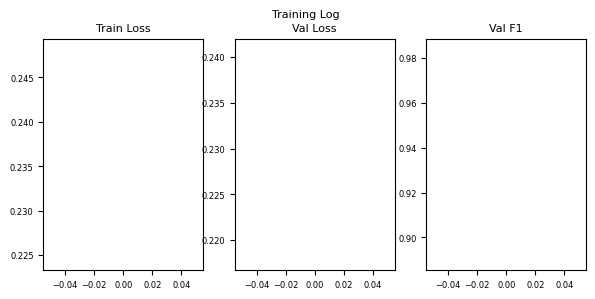

Epoch 0
Train loss: 0.236
Train micro F1: 0.938
Validation loss: 0.229
Validation micro F1: 0.937
Epoch time: 1733.305s


In [92]:
answer_model.train(train_dataloader, val_dataloader, 1, optimizer)

In [17]:
# torch.save(model.state_dict(), 'long_model.pt')

In [19]:
# model = torch.load('long_model.pt')

### Test model

In [ ]:
from tqdm import tqdm

In [ ]:
def get_inds(labels, indices):
    if 1 not in labels:
        return '-1:-1'
    ind = labels.index(1)
    return indices[ind]

In [ ]:
pred, gold = [], []

for batch in tqdm(dataset3):
    encoding, labels, indices = batch
    answer = answer_model(encoding['input_ids'], encoding['attention_mask'])
    pred.append(get_inds(answer.cpu().tolist(), indices))
    gold.append(get_inds(labels, indices))

In [ ]:
print(f"F score: {f1_score(pred, gold, average='micro'):.4f}")

### How to balance data?

[resample](https://elitedatascience.com/imbalanced-classes)

In [104]:
from sklearn.utils import resample, shuffle

In [89]:
data_unbalanced = dataset2.data.copy()

In [90]:
data_unbalanced.head()

,question,long_answer,is_long_answer
0,becomes chief resident grey's anatomy season 7,April Kepner Grey 's Anatomy character ...,0
1,becomes chief resident grey's anatomy season 7,Religion Christianity,0
2,becomes chief resident grey's anatomy season 7,Kepner reveals virgin Christian made promise ...,1
3,becomes chief resident grey's anatomy season 7,"In Season 12 , April Jackson go divorce proce...",0
4,list environmentally critical areas philippines,This list protected areas Philippines adminis...,0


In [91]:
data_unbalanced_majority = data_unbalanced[data_unbalanced.is_long_answer == 0]
data_unbalanced_minority = data_unbalanced[data_unbalanced.is_long_answer == 1]

In [92]:
data_unbalanced_majority.shape[0]

10200

In [93]:
data_unbalanced_minority.shape[0]

541

In [95]:
data_balanced_minority = resample(data_unbalanced_minority, 
                                  replace=True,
                                  n_samples=10200)

In [96]:
data_balanced_minority.shape[0]

10200

In [97]:
data_balanced_minority.head()

,question,long_answer,is_long_answer
7015,played daughters last man standing,Tim Allen Mike Baxter : Mike father three da...,1
567,played detective little boy blue,Stephen Graham -- Detective Superintendent Da...,1
10398,non controlling interest balance sheet,"In accounting , minority interest ( non-contr...",1
3161,great wall china built defend,The history Great Wall China began fortificat...,1
4007,plays little girl jurassic park,"Ariana Clarice Richards ( born September 11 ,...",1


In [99]:
data_balanced_minority.drop_duplicates().shape[0]

541

In [100]:
data_balanced = pd.concat([data_unbalanced_majority, data_balanced_minority])

In [101]:
data_balanced.shape[0]

20400

In [111]:
data_balanced = shuffle(data_balanced)

In [112]:
data_balanced.head()

,question,long_answer,is_long_answer
759,justin bieber's purpose song,"Australia ( ARIA ) 3 × Platinum 210,000",0
10399,non controlling interest balance sheet,Some investors expressed concern minority int...,0
4279,season 2 attack titan many episodes,Season Episodes Originally aired Fi...,1
2783,summer monkeys take place,The book set end nineteenth century . The pro...,1
9230,attack pearl harbor take place,Attack Pearl Harbor,0


In [113]:
data_balanced.reset_index(drop=True).head()

,question,long_answer,is_long_answer
0,justin bieber's purpose song,"Australia ( ARIA ) 3 × Platinum 210,000",0
1,non controlling interest balance sheet,Some investors expressed concern minority int...,0
2,season 2 attack titan many episodes,Season Episodes Originally aired Fi...,1
3,summer monkeys take place,The book set end nineteenth century . The pro...,1
4,attack pearl harbor take place,Attack Pearl Harbor,0
